In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy.special as sp
import IGM

r0 = 2.818e-13 # classical electron radius in cm
m_e = 9.10938e-28 # electron mass in gram
c = 2.998e10 # speed of light in cm/s
h = 6.6261e-27 # planck constant in cm^2 g s-1
eV_to_erg = 1.6022e-12
parsec_to_cm = 3.085677581e18 # cm per parsec

kB = 1.3808e-16 # boltzmann constant in cm^2 g s^-2 K^-1
T_CMB = 2.725 # CMB temperature today in K

H_0 = 2.184e-18 # current hubble constant in s^-1
H_r = 3.24076e-18 # 100 km/s/Mpc to 1/s
h_0 = H_0 / H_r
omega_b_0 = 0.0224 / h_0 / h_0  # current baryon abundance
m_p = 1.67262193269e-24 # proton mass in g
G = 6.6743e-8 # gravitational constant in cm^3 g^-1 s^-2
f_He = 0.079 # helium mass fraction
f_H = 0.76 # hydrogen fraction
Y_He = 0.24

E_e = m_e * c * c
rho_crit = 3 * H_0 * H_0 / 8 / np.pi / G
e = 4.80326e-10 # electron charge in esu

z = 2
z2 = (1 + z) / 3
T_CMB *= 1 + z 

T_IGM = 9245.6 # IGM temperature at z = 2 in K

In [2]:
omega_b = omega_b_0 * (1 + z)**3
mean_n_b = 3 * omega_b * H_0 * H_0 / (8 * np.pi * G * m_p) # mean number density of baryons at the redshift
n_b = mean_n_b # for mean density
    
n_H = n_b * (1 - Y_He) # nuclei in hydrogen
n_He = n_H * f_He # nuclei in helium, assume He is all 4He

n_e = n_H + 2 * n_He # for fully ionized

In [4]:
omega_p = c * np.sqrt(4 * np.pi * r0 * n_e)

k = omega_p / c * np.array([1.01, 1.05, 1.1, 1.5, 2]) # wave number
theta_deg = np.array([5, 45, 85])
theta_rad = np.radians(theta_deg)

In [5]:
print(omega_p/c, k[0], theta_rad[0])

4.6007454504527044e-09 4.646752904957231e-09 0.08726646259971647


In [6]:
n = n_e + n_H + n_He

B = np.sqrt(8 * np.pi * kB * T_IGM * n) # equipartion field

omega_c = e * B / (m_e * c)

In [32]:
print(B, omega_c)

1.924794461998326e-08 0.3385322193458688


In [7]:
def dispersion(omega, k, theta_rad):
    res = omega**2 - omega_p**2 / (1 - omega_c**2 / omega**2) - c**2 * k**2 * np.cos(theta_rad)**2 - 1 / (1 - omega_c**2 / omega**2) * omega_c**2 * omega_p**4 / ((omega**2 - c**2 * k**2) * (omega**2 - omega_c**2) - omega_p**2 * omega**2) - c**4 * k**4 * np.sin(theta_rad)**2 * np.cos(theta_rad)**2 / (omega**2 - omega_p**2 - c**2 * k**2 * np.sin(theta_rad)**2)
    return res

In [8]:
# grid has shape (len(k), len(angle)), same row same k, same col same angle
omega = np.zeros((len(k), len(theta_rad)))

for i in range(len(k)):
    for j in range(len(theta_rad)):
        dispersion_fixed = lambda omega: dispersion(omega, k[i], theta_rad[j])
        initial_guess = omega_p/10
        omega[i][j] = fsolve(dispersion_fixed, initial_guess)[0]

In [29]:
print(omega_p)
print(omega)

137.9303486045721
[[195.95732985 137.9303527  137.93035673]
 [199.91889268 137.93036792 137.93038693]
 [204.97198864 137.93038466 137.93042016]
 [248.60564295 137.93046401 137.93057765]
 [137.93035097 137.9305044  137.93065782]]


In [28]:
test = np.zeros((len(k), len(theta_rad)))
for i in range(len(k)):
    for j in range(len(theta_rad)):
        test[i][j] = dispersion(omega[i][j], k[i], theta_rad[j])
        
print(np.min(test), np.max(test))

-9.536051948089153e-10 5.616684006781725e-08


In [10]:
def get_eigen(omega, k, theta_rad):
    zeta_x = np.array([np.sin(theta_rad), 0, np.cos(theta_rad)]) # for now, as zeta will be canceled out later
    zeta_y = 1j * omega_c * omega_p**2 * omega / ((omega**2 - c**2 * k**2) * (omega**2 - omega_c**2) - omega_p**2 * omega**2) * zeta_x
    zeta_z = -c**2 * k**2 * np.sin(theta_rad) * np.cos(theta_rad) / (omega**2 - omega_p**2 - c**2 * k**2 * np.sin(theta_rad)**2) * zeta_x
    return zeta_x, zeta_y, zeta_z

In [11]:
def get_D(i, j):
    omega_ij = omega[i][j]
    zeta_x, zeta_y, zeta_z = get_eigen(omega_ij, k[i], theta_rad[j])
    mag2_x = zeta_x[0]**2 + zeta_x[1]**2 + zeta_x[2]**2
    mag2_y = np.abs(zeta_y[0])**2 + np.abs(zeta_y[1])**2 + np.abs(zeta_y[2])**2
    mag2_z = zeta_z[0]**2 + zeta_z[1]**2 + zeta_z[2]**2
    mag2_zeta = mag2_x + mag2_y + mag2_z
    
    add1 = 2 * omega_ij * mag2_zeta
    co1 = omega_p**2 * omega_c**2 / (omega_ij**3 * (1 - omega_c**2 / omega_ij**2)**2)
    co2 = 2 * (mag2_x + mag2_y) - 1j * (np.dot(np.conj(zeta_x), zeta_y) - np.dot(np.conj(zeta_y), zeta_x)) / omega_c * omega_ij * (1 + omega_c**2 / omega_ij**2)
    return add1 + co1 * co2.real # co2 is always xxx + 0j, only real part make sense

In [12]:
D = np.zeros((len(k), len(theta_rad)))
for i in range(len(k)):
    for j in range(len(theta_rad)):
        D[i][j] = get_D(i, j)

In [31]:
print(2*omega_p)
print(D)

275.8606972091442
[[  789.50348398   551.72310466   277.97385496]
 [  805.48302656   551.72327357   277.97380946]
 [  825.86453835   551.72343874   277.9737797 ]
 [ 1001.8272327    551.72392811   277.97392777]
 [36316.06711673   551.72399094   277.97418655]]


In [13]:
IGM_00 = IGM.IGM_N(0,0) # mean density
n_CRe = IGM_00.back_Euler() # number density of CRe, shape (399, 399)
E = IGM.E
gamma = E / E_e + 1

In [15]:
np.save('n_CRe.npy', n_CRe)

In [14]:
print(IGM_00.z[240])
n_CRe_z2 = n_CRe[:, 240] # number density of CRe at z = 2, shape (399,)
n_CRe_z2 = np.insert(n_CRe_z2, 0, 0) # insert 0 at beginning for calculation, shape (400, )

2.0083681725319145


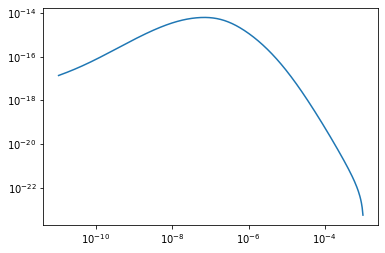

In [39]:
plt.plot(IGM.E[1:], n_CRe_z2[1:])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [16]:
p = gamma * m_e * c # shape (400, )
omega_s = omega_c / gamma # shape (400, )

In [17]:
def get_n_Bessel(omega, k_para, omega_s):
    # cos(alpha) = (omega - n * omega_s) / k_parallel / v
    n_b1 = (omega - k_para * c) / omega_s
    n_b2 = (omega + k_para * c) / omega_s
    
    lower_bound = int(min(n_b1, n_b2)) + 1
    upper_bound = int(max(n_b1, n_b2))
    
    #print((omega - n_b1 * omega_s) / k_para / c)
    #print((omega - n_b2 * omega_s) / k_para / c)
    
    return np.array(range(lower_bound, upper_bound + 1))

In [18]:
print(get_n_Bessel(omega[0][0], k[0]*np.cos(theta_rad[0]), omega_s[0]))

[169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294
 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366
 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384
 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402
 403 404 405 406 407 408 409 410 411 412 413 414 41

In [50]:
def get_Bessel(omega, n_Bessel, omega_s, k_para, k_orth, k, theta_rad):
    cosa = (omega - n_Bessel * omega_s) / k_para / c
    sina = np.sqrt(1 - cosa**2)
    
    z_Bessel = k_orth * c * sina / omega_s
    #print(z_Bessel)
    Jnz = sp.jv(n_Bessel, z_Bessel)
    Jnz_p = sp.jvp(n_Bessel, z_Bessel, n=1)
    
    zeta_x, zeta_y, zeta_z = get_eigen(omega, k, theta_rad)
    
    res_v = n_Bessel / z_Bessel * Jnz * zeta_x * sina + Jnz * zeta_z * cosa + Jnz_p * zeta_y / 1j * sina
    #print(res_v)
    res = res_v[0].real**2 + res_v[1].real**2 + res_v[2].real**2
    #print(res)
    
    return res

In [49]:
get_Bessel(omega[0][0], 200, omega_s[0], k[0]*np.cos(theta_rad[0]), k[0]*np.sin(theta_rad[0]), k[0], theta_rad[0])

13.702740337217719
[-1.11630212e-210+0.j  0.00000000e+000+0.j -1.27593916e-209+0.j]
0.0


0.0

In [51]:
def get_int(i, j):
    k_para = k[i] * np.cos(theta_rad[j])
    k_orth = k[i] * np.sin(theta_rad[j])
    
    int_sum = 0
    for pi in range(len(p)-1):
        Delta = omega_s[pi] / (np.abs(k_para) * c)
        co1 = p[pi]**2 * (p[pi+1] - p[pi]) * (n_CRe_z2[pi+1] - n_CRe_z2[pi]) * m_e * c * Delta / omega_s[pi]
        
        n_Bessel = get_n_Bessel(omega[i][j], k_para, omega_s[pi])
        print(pi, n_Bessel.shape)
        sum_Bessel = sum(get_Bessel(omega[i][j], ni_Bessel, omega_s[pi], k_para, k_orth, k[i], theta_rad[j]) for ni_Bessel in n_Bessel)
        int_sum = int_sum + co1 * sum_Bessel
        
    return int_sum

In [22]:
def get_damp_rate(i, j):
    res = 2 * np.pi**2 * omega_p**2 * omega[i][j] / (D[i][j] * n_e) * get_int(i,j)
    return res

In [54]:
print(get_damp_rate(2, 0)) # k = 1.1 omega_p/c, theta = 5 degree

0 (893,)
1 (892,)
2 (892,)
3 (892,)
4 (892,)
5 (892,)
6 (892,)
7 (892,)
8 (892,)
9 (892,)
10 (892,)
11 (892,)
12 (892,)
13 (892,)
14 (892,)
15 (892,)
16 (892,)
17 (892,)
18 (892,)
19 (892,)
20 (892,)
21 (892,)
22 (892,)
23 (892,)
24 (892,)
25 (892,)
26 (892,)
27 (892,)
28 (892,)
29 (892,)
30 (892,)
31 (893,)
32 (893,)
33 (893,)
34 (893,)
35 (893,)
36 (893,)
37 (893,)
38 (893,)
39 (893,)
40 (893,)
41 (893,)
42 (893,)
43 (893,)
44 (893,)
45 (893,)
46 (893,)
47 (893,)
48 (893,)
49 (893,)
50 (893,)
51 (893,)
52 (893,)
53 (893,)
54 (893,)
55 (893,)
56 (893,)
57 (893,)
58 (893,)
59 (893,)
60 (893,)
61 (893,)
62 (893,)
63 (893,)
64 (893,)
65 (893,)
66 (893,)
67 (893,)
68 (893,)
69 (893,)
70 (893,)
71 (893,)
72 (893,)
73 (893,)
74 (893,)
75 (893,)
76 (893,)
77 (893,)
78 (893,)
79 (893,)
80 (893,)
81 (893,)
82 (893,)
83 (893,)
84 (893,)
85 (893,)
86 (893,)
87 (893,)
88 (893,)
89 (893,)
90 (893,)
91 (893,)
92 (893,)
93 (893,)
94 (893,)
95 (893,)
96 (894,)
97 (894,)
98 (894,)
99 (894,)
100 (894,)

In [55]:
print(get_damp_rate(2, 2)) # k = 1.1 omega_p/c, theta = 85 degree

0 (78,)
1 (78,)
2 (78,)
3 (78,)
4 (78,)
5 (78,)
6 (78,)
7 (78,)
8 (78,)
9 (78,)
10 (78,)
11 (78,)
12 (78,)
13 (78,)
14 (78,)
15 (78,)
16 (78,)
17 (78,)
18 (78,)
19 (78,)
20 (78,)
21 (78,)
22 (78,)
23 (78,)
24 (78,)
25 (78,)
26 (78,)
27 (78,)
28 (78,)
29 (78,)
30 (78,)
31 (78,)
32 (78,)
33 (78,)
34 (78,)
35 (78,)
36 (78,)
37 (78,)
38 (78,)
39 (78,)
40 (78,)
41 (78,)
42 (78,)
43 (78,)
44 (78,)
45 (78,)
46 (78,)
47 (78,)
48 (78,)
49 (78,)
50 (78,)
51 (78,)
52 (78,)
53 (78,)
54 (78,)
55 (78,)
56 (78,)
57 (78,)
58 (78,)
59 (78,)
60 (78,)
61 (78,)
62 (78,)
63 (78,)
64 (78,)
65 (78,)
66 (78,)
67 (78,)
68 (78,)
69 (78,)
70 (78,)
71 (78,)
72 (78,)
73 (78,)
74 (78,)
75 (78,)
76 (78,)
77 (78,)
78 (78,)
79 (78,)
80 (78,)
81 (78,)
82 (78,)
83 (78,)
84 (78,)
85 (78,)
86 (78,)
87 (78,)
88 (78,)
89 (78,)
90 (78,)
91 (78,)
92 (78,)
93 (78,)
94 (78,)
95 (78,)
96 (78,)
97 (78,)
98 (79,)
99 (79,)
100 (79,)
101 (79,)
102 (79,)
103 (79,)
104 (79,)
105 (79,)
106 (79,)
107 (78,)
108 (78,)
109 (78,)
110 (78,)


### ignore the following part, didn't finish running

In [23]:
import time

damp_rate = np.zeros((len(k), len(theta_rad)))
time_start = time.time()
for j in range(len(theta_rad)):
    for i in range(len(k)):
        print(f'i = {i}, j = {j}, {(time.time() - time_start)/60}')
        damp_rate[i][j] = get_damp_rate(i, j)
        np.save('damp_rate.npy', damp_rate)

i = 0, j = 0, 4.267692565917968e-06
0 (820,)
1 (820,)
2 (820,)
3 (820,)
4 (820,)
5 (820,)
6 (820,)
7 (820,)
8 (820,)
9 (820,)
10 (820,)
11 (820,)
12 (820,)
13 (820,)
14 (820,)
15 (820,)
16 (820,)
17 (820,)
18 (820,)
19 (820,)
20 (820,)
21 (820,)
22 (820,)
23 (820,)
24 (820,)
25 (820,)
26 (820,)
27 (820,)
28 (820,)
29 (820,)
30 (820,)
31 (820,)
32 (820,)
33 (820,)
34 (820,)
35 (820,)
36 (820,)
37 (820,)
38 (820,)
39 (820,)
40 (820,)
41 (820,)
42 (820,)
43 (820,)
44 (820,)
45 (820,)
46 (820,)
47 (820,)
48 (820,)
49 (820,)
50 (820,)
51 (820,)
52 (820,)
53 (820,)
54 (820,)
55 (820,)
56 (820,)
57 (820,)
58 (820,)
59 (820,)
60 (820,)
61 (820,)
62 (821,)
63 (821,)
64 (821,)
65 (821,)
66 (821,)
67 (821,)
68 (821,)
69 (821,)
70 (821,)
71 (821,)
72 (821,)
73 (821,)
74 (821,)
75 (821,)
76 (821,)
77 (821,)
78 (821,)
79 (821,)
80 (821,)
81 (821,)
82 (821,)
83 (821,)
84 (821,)
85 (820,)
86 (820,)
87 (820,)
88 (820,)
89 (820,)
90 (820,)
91 (820,)
92 (820,)
93 (820,)
94 (820,)
95 (820,)
96 (820,)
97 (

KeyboardInterrupt: 

In [24]:
#same row same k, same col same theta
#k = omega_p / c * np.array([1.01, 1.05, 1.1, 1.5, 2]) # wave number
#theta_deg = np.array([5, 45, 85])
#theta_rad = np.radians(theta_deg)

print(damp_rate)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.21502162e-73  0.00000000e+00  0.00000000e+00]]
